# Effect of instantaneous weather sampling rate on subhourly clipping errors - SURFRAD-sxf
These notebooks resample the SURFRAD network data at different frequencies to simulate satellite data.

In [1]:
import calendar
from dataclasses import dataclass
import pathlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
import seaborn as sns
from tqdm import tqdm

In [2]:
sns.set(font_scale=1.5, rc={'figure.figsize': (12, 8)})

In [3]:
# CONSTANTS
# https://gml.noaa.gov/grad/surfrad/sitepage.html
SURFRAD_TZ = {
    'bon': '-06:00', 'tbl': '-07:00', 'dra': '-08:00', 'fpk': '-07:00',
    'gwn': '-06:00', 'psu': '-05:00', 'sxf': '-06:00'}

## Some useful functions
* `read_surfrad_year` just reads all daily files from a yearly surfrad folder

In [4]:
def read_surfrad_year(surfrad_year_path):
    """
    Parameters
    -----------
    surfrad_year_path : pathlib.Path
        path to folder containing a single year of daily SURFRAD data files
    Returns
    -------
    df : pandas.DataFrame
        All of the daily weather data from folder of single year concatentated
        along time axis
    header : dict
        info about the location, timezone, and station name
    """
    data = [pvlib.iotools.read_surfrad(f) for f in surfrad_year_path.iterdir()]
    dfs, heads = zip(*data)
    df = pd.concat(dfs)
    header = heads[0]
    return df, header

## Accessing SURFRAD data
SURFRAD has 7 stations. pvlib-python has functions to download data from SURFRAD, but it takes a while, so I have previously downloaded and cached the data in folders for each station. Inside each station folder, there are folders for each year with data. Most stations began measurements in 1995 and continuously add new data one day at a time. These daily data files are stored in the yearly folders.

Here I specify the path the SURFRAD folder that contains all of the stations and then pick a single station to look at in this folder. Later we can try to manipulate all of the stations after working out the algorithms.

In [5]:
# specify path to all SURFRAD station data
surfrad_dir = pathlib.Path('../../SURFRAD')
print(f'Is there really a \33[1m\33[91m"SURFRAD"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{surfrad_dir.exists()} \u2713\33[0m\33[0m')

Is there really a "SURFRAD" directory? True ✓


In [6]:
# specify path to just a single station, EG: Bondville, IL
weather_dir = "Sioux_Falls_SD"
weather_path = surfrad_dir / weather_dir
print(f'Is there really a \33[1m\33[91m"{weather_path}"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{weather_path.exists()} \u2713\33[0m\33[0m')

Is there really a "..\..\SURFRAD\Sioux_Falls_SD" directory? True ✓


In [7]:
# display what years are in the SURFRAD station folder
weather_year_paths = weather_path.iterdir()
years = [p.parts[-1] for p in weather_year_paths]
', '.join(years)

'2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021'

## Narrowing Selection
There are a lot of years in a single station because SURFRAD has been operating for over 25 years! We can narrow our selection and make our work easier by checking:
* timestep or time-interval
* completeness of the year
* containing all of the required data

### Timesteps
SURFRAD stations collect data at either 3-minute or 1-minute intervals. For example, up until 2009, the Bondville, IL, station collected data at 3-minute intervals and then afterwards colected at 1-minute intervals. I narrow the selection by only using 1-minute intervals.

### Yearly Completeness
Each year has missing data, so I further narrow the selection by only using years that are at least 98% complete.

### Data Fields
Some of the fields are also missing. For example 1995 is missing all of the diffuse horizontal irradiance and about half of the air temperature data. I further narrow the selection by only using years with GHI, DHI, DNI, air temperature, wind speed, and solar zenith. This is a complete data set.

In [8]:
# how many years are missing data?
REQD_COLS = ['ghi', 'dhi', 'dni', 'solar_zenith', 'wind_speed', 'temp_air', 'pressure', 'relative_humidity']
weather_years = dict.fromkeys(years)
weather_stats = pd.DataFrame(index=years, columns=['Number of Records', 'Expected', 'Timestep', 'Completeness'])
for weather_year in tqdm(weather_path.iterdir()):
    weather_df, weather_header = read_surfrad_year(weather_year)
    year = weather_year.parts[-1]
    dt = np.diff(weather_df.index).min().seconds/60
    weather_years[year] = weather_df[REQD_COLS].dropna()
    num_recs = weather_years[year].shape[0]
    daze = 365*24*60/dt
    if calendar.isleap(int(year)):
        daze += (24*60/dt)
    frac_recs = num_recs/daze
    weather_stats.loc[year] = (num_recs, daze, dt, frac_recs)
weather_stats

19it [07:14, 22.86s/it]


,Number of Records,Expected,Timestep,Completeness
2003,95349,175200.0,3.0,0.544229
2004,175052,175680.0,3.0,0.996425
2005,172375,175200.0,3.0,0.983876
2006,164215,175200.0,3.0,0.9373
2007,172648,175200.0,3.0,0.985434
2008,174995,175680.0,3.0,0.996101
2009,523883,525600.0,1.0,0.996733
2010,523562,525600.0,1.0,0.996123
2011,519510,525600.0,1.0,0.988413
2012,515443,527040.0,1.0,0.977996


In [9]:
weather_header

{'name': 'Sioux Falls',
 'latitude': 43.73,
 'longitude': -96.62,
 'elevation': 473.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

In [10]:
weather_df.columns

Index(['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith',
       'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag',
       'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp',
       'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir',
       'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp',
       'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar',
       'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag',
       'temp_air', 'temp_air_flag', 'relative_humidity',
       'relative_humidity_flag', 'wind_speed', 'wind_speed_flag',
       'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag'],
      dtype='object')

## QA/QC
Selecting only years that are > 98% complete and have 1-minute timestep, we reduce the number of years to 8: from 2010-2015, 2017, 2019

In [11]:
is_dt_1min = (weather_stats['Timestep'].values.astype(int) == 1)
is_98pct_complete = (weather_stats['Completeness'].values >= 0.98)
selected_years = weather_stats[is_dt_1min & is_98pct_complete]
selected_years

,Number of Records,Expected,Timestep,Completeness
2009,523883,525600.0,1.0,0.996733
2010,523562,525600.0,1.0,0.996123
2011,519510,525600.0,1.0,0.988413
2013,517121,525600.0,1.0,0.983868
2014,518078,525600.0,1.0,0.985689
2015,522254,525600.0,1.0,0.993634
2016,523196,527040.0,1.0,0.992706
2020,517088,527040.0,1.0,0.981117


In [12]:
# pop the unselected years from weather_years
for year in years:
    if year not in selected_years.index:
        print(f'{year}: {weather_stats.loc[year, "Completeness"]} complete and {weather_stats.loc[year, "Timestep"]}-min timestep')
        weather_years.pop(year)
list(weather_years.keys())

2003: 0.5442294520547946 complete and 3.0-min timestep
2004: 0.9964253187613843 complete and 3.0-min timestep
2005: 0.9838755707762558 complete and 3.0-min timestep
2006: 0.9373002283105023 complete and 3.0-min timestep
2007: 0.985433789954338 complete and 3.0-min timestep
2008: 0.9961008652094717 complete and 3.0-min timestep
2012: 0.977995977534912 complete and 1.0-min timestep
2017: 0.9381697108066971 complete and 1.0-min timestep
2018: 0.9292846270928463 complete and 1.0-min timestep
2019: 0.9779604261796042 complete and 1.0-min timestep
2021: 0.07301750380517504 complete and 1.0-min timestep


['2009', '2010', '2011', '2013', '2014', '2015', '2016', '2020']

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:20<00:00,  2.59s/it]


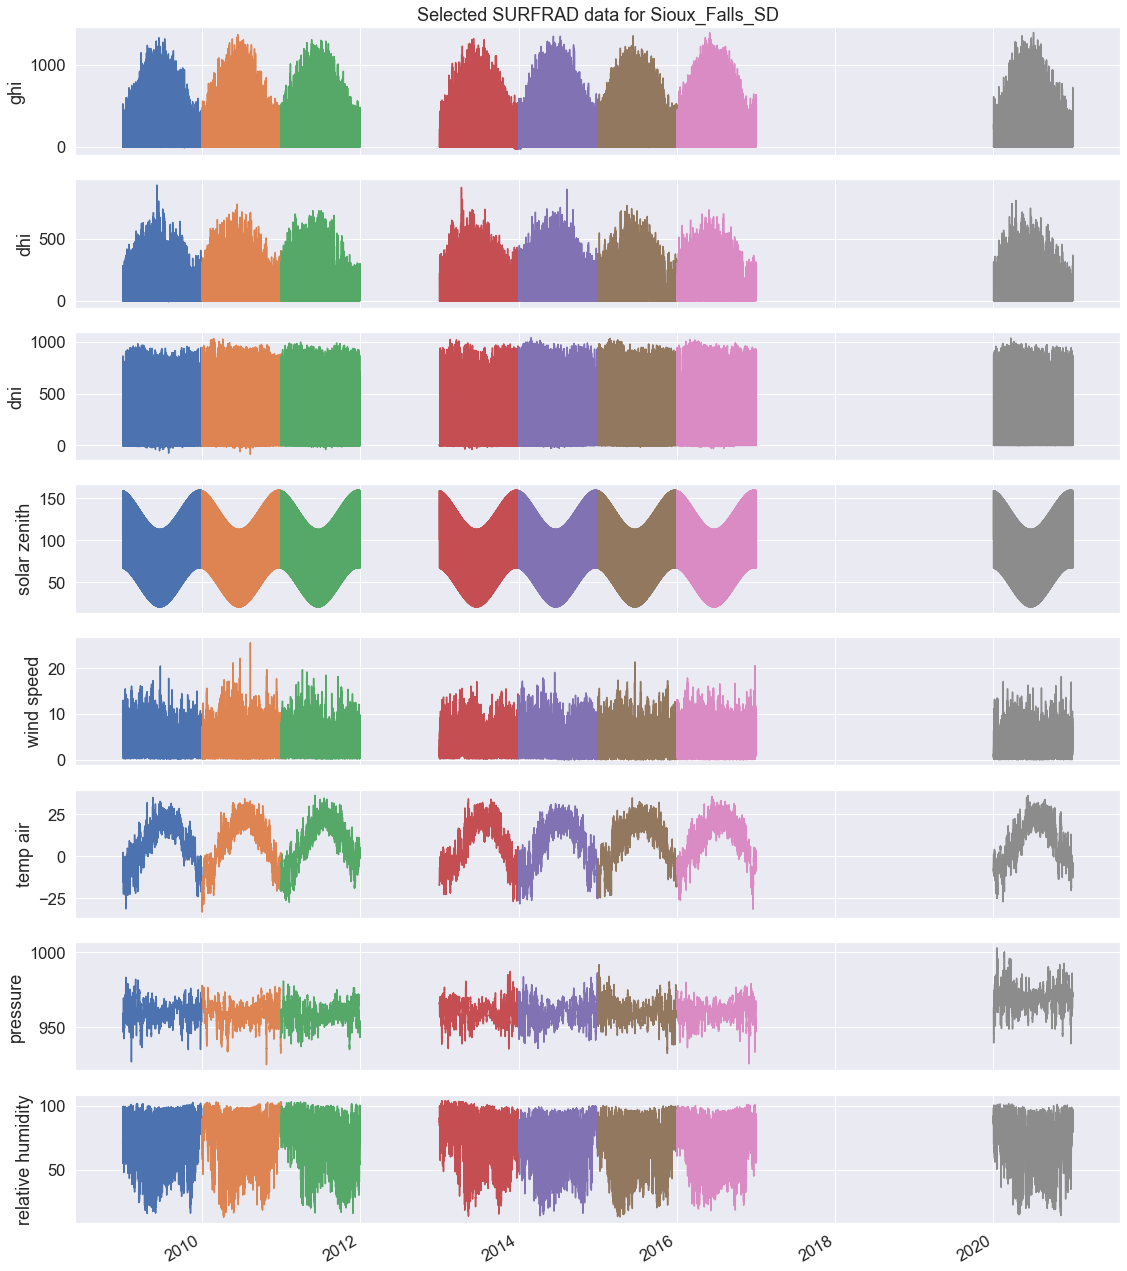

In [13]:
f, ax = plt.subplots(len(REQD_COLS), 1, sharex=True, figsize=(16, 18))
for n, k in enumerate(REQD_COLS):
    for year in tqdm(selected_years.index):
        #print(f'making plot of {k} for {year}')
        weather_years[year][k].plot(ax=ax[n])
    ax[n].set_ylabel(k.replace('_', ' '))
ax[0].set_title(f'Selected SURFRAD data for {weather_dir}')
f.tight_layout()

In [14]:
LATITUDE = weather_header['latitude']
LONGITUDE = weather_header['longitude']
ELEVATION = weather_header['elevation']
YEAR = selected_years.index[0]
print(f'year: {YEAR}')
TIMES = weather_years[YEAR].index

year: 2009


In [15]:
TIMES

DatetimeIndex(['2009-01-01 00:32:00+00:00', '2009-01-01 00:34:00+00:00',
               '2009-01-01 00:35:00+00:00', '2009-01-01 00:36:00+00:00',
               '2009-01-01 00:37:00+00:00', '2009-01-01 00:38:00+00:00',
               '2009-01-01 00:39:00+00:00', '2009-01-01 00:40:00+00:00',
               '2009-01-01 00:41:00+00:00', '2009-01-01 00:42:00+00:00',
               ...
               '2009-12-31 23:50:00+00:00', '2009-12-31 23:51:00+00:00',
               '2009-12-31 23:52:00+00:00', '2009-12-31 23:53:00+00:00',
               '2009-12-31 23:54:00+00:00', '2009-12-31 23:55:00+00:00',
               '2009-12-31 23:56:00+00:00', '2009-12-31 23:57:00+00:00',
               '2009-12-31 23:58:00+00:00', '2009-12-31 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', length=523883, freq=None)

In [16]:
df = weather_years[YEAR]
df.head()

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2009-01-01 00:32:00+00:00,-4.7,-1.7,1.3,105.95,11.2,-9.4,959.2,71.9
2009-01-01 00:34:00+00:00,-4.7,-1.6,1.3,106.29,10.6,-9.4,959.1,72.2
2009-01-01 00:35:00+00:00,-4.7,-1.7,1.3,106.47,10.4,-9.4,959.1,72.0
2009-01-01 00:36:00+00:00,-4.7,-1.7,1.1,106.64,9.9,-9.5,959.1,72.4
2009-01-01 00:37:00+00:00,-4.8,-1.7,0.9,106.81,9.9,-9.5,959.1,72.2


In [17]:
# get solar position
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values

In [18]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
print(f'zenith MBE: {ze_mbe}%')

zenith MBE: 0.0032134700181756957%


## Load SURFRAD daily weather data
Each day is in a separate file. We already read this in using pvlib

In [19]:
# how many days are in this file
weather_year_paths = list(weather_path.iterdir())
year_idx = weather_year_paths.index(weather_path / YEAR)
weather_year_day_files = list(weather_year_paths[year_idx].iterdir())
CODENAME = weather_year_day_files[0].stem[:3]
TZ = SURFRAD_TZ[CODENAME]
print(f'{CODENAME} timezone: {TZ}')
day_files = {int(d.parts[-1][5:-4]) for d in weather_year_day_files}
len(day_files)

sxf timezone: -06:00


365

In [20]:
# missing days
missing_days = set(range(1, 366)) - day_files
missing_days

set()

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'dni'`
* global horizontal irradiance (GHI): `'ghi'`
* diffuse horizontal irradiance (DHI): `'dhi'`
* solar zenith: `'solar_zenith'`
* wind speed: `'wind_speed'`
* air temperature: `'temp_air'`

In [21]:
# view a few timestamps to sanity check (E. Tufte, ...)
df[f'{YEAR}-07-07T12:09:00{TZ}':f'{YEAR}-07-07T12:18:00{TZ}'][REQD_COLS]  # <-- XXX: pick dates for each month

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2009-07-07 18:09:00+00:00,747.1,478.3,310.2,21.74,4.0,26.2,955.6,57.2
2009-07-07 18:10:00+00:00,700.3,478.1,266.1,21.70,1.8,26.1,955.6,58.4
2009-07-07 18:11:00+00:00,658.8,477.0,223.8,21.65,2.8,26.3,955.6,58.8
2009-07-07 18:12:00+00:00,656.2,475.4,223.5,21.61,3.1,26.2,955.6,57.7
2009-07-07 18:13:00+00:00,673.3,474.9,244.1,21.57,3.5,26.2,955.6,57.9
2009-07-07 18:14:00+00:00,634.9,471.5,202.5,21.54,4.5,26.1,955.6,59.0
2009-07-07 18:15:00+00:00,655.7,468.8,221.3,21.50,4.5,26.0,955.6,57.7
2009-07-07 18:16:00+00:00,663.9,467.2,230.4,21.47,4.1,25.9,955.6,58.2
2009-07-07 18:17:00+00:00,681.4,467.3,250.3,21.44,2.9,25.9,955.6,57.9
2009-07-07 18:18:00+00:00,666.4,467.4,238.3,21.41,1.5,26.0,955.6,59.5


In [22]:
JULY7_MORN, JULY7_NITE = f'{YEAR}-07-07T04:00:00{TZ}', f'{YEAR}-07-07T20:00:00{TZ}'
JAN7_MORN, JAN7_NITE = f'{YEAR}-01-07T06:00:00{TZ}', f'{YEAR}-01-07T18:00:00{TZ}'

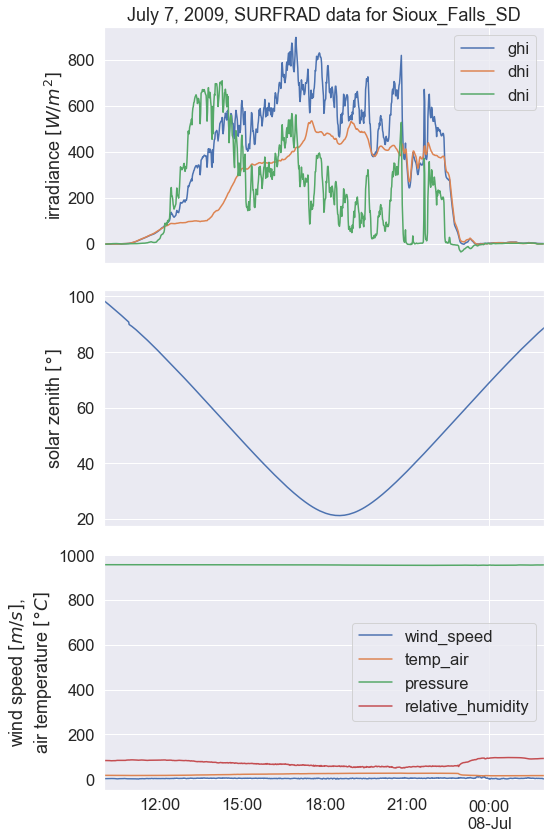

In [23]:
f, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
df[JULY7_MORN:JULY7_NITE][REQD_COLS[:3]].plot(ax=ax[0])
ax[0].set_title(f'July 7, {YEAR}, SURFRAD data for {weather_dir}')
ax[0].set_ylabel('irradiance $[W/m^2]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[3]].plot(ax=ax[1])
ax[1].set_ylabel('solar zenith $[\degree]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[4:]].plot(ax=ax[2])
ax[2].set_ylabel('wind speed $[m/s]$,\nair temperature $[\degree C]$')
f.tight_layout()

## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [24]:
dni = np.maximum(0, df['dni'])
ghi = np.maximum(0, df['ghi'])
dhi = np.maximum(0, df['dhi'])
zerad = np.radians(df['solar_zenith'])
dhi_calc = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI calc')
irr_check = pd.concat([dni, ghi, dhi, dhi_calc], axis=1)

In [25]:
# check the calculated zenith from SURFRAD
dhi_mbe = 100 * (
    sum(dhi.resample('D').sum() - dhi_calc.resample('D').sum())
    / sum(dhi.resample('D').sum()))
print(f'dhi MBE: {dhi_mbe}%')

dhi MBE: 7.128331616177566%


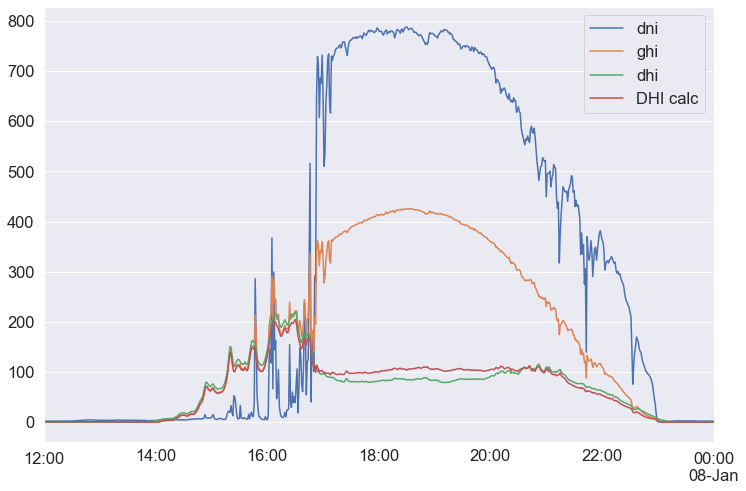

In [26]:
irr_check[JAN7_MORN:JAN7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

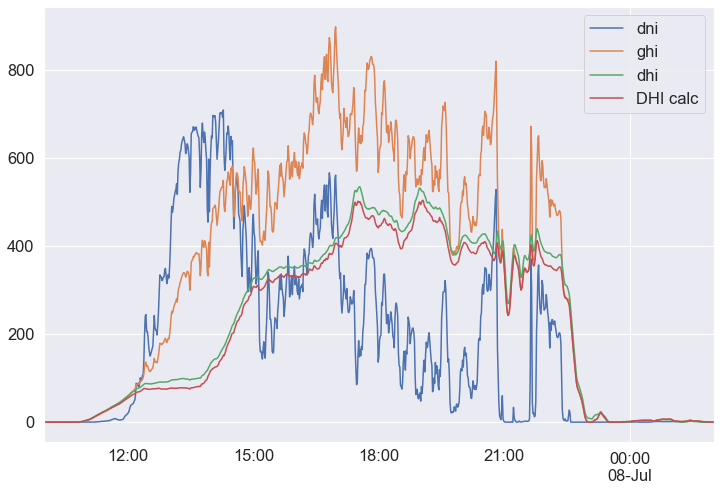

In [27]:
irr_check[JULY7_MORN:JULY7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI
3. Temp
4. WS

In [28]:
# get other parameters needed for modeling like windspeed and air temp
wspd = df['wind_speed']
tair = df['temp_air']

In [29]:
weather = pd.concat([ghi, dni, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DNI', 'DHI', 'Temp', 'WS']
weather.head()

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-01 00:32:00+00:00,0.0,1.3,0.0,-9.4,11.2
2009-01-01 00:34:00+00:00,0.0,1.3,0.0,-9.4,10.6
2009-01-01 00:35:00+00:00,0.0,1.3,0.0,-9.4,10.4
2009-01-01 00:36:00+00:00,0.0,1.1,0.0,-9.5,9.9
2009-01-01 00:37:00+00:00,0.0,0.9,0.0,-9.5,9.9


In [30]:
weather.loc[f'{YEAR}-01-01T08:21:00{TZ}']  # <-- XXX: pick dates for each month

GHI     3.4
DNI     2.6
DHI     5.7
Temp   -5.8
WS      2.5
Name: 2009-01-01 14:21:00+00:00, dtype: float64

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [31]:
weather5inst = weather.resample('5T').first()
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-07 12:00:00+00:00,0.000000,2.775000,0.000000,-15.600000,4.316667
2009-01-07 13:00:00+00:00,0.000000,3.583333,0.083333,-15.566667,4.375000
2009-01-07 14:00:00+00:00,17.316667,5.250000,21.750000,-15.241667,3.883333
2009-01-07 15:00:00+00:00,101.375000,14.583333,109.608333,-14.525000,4.525000
2009-01-07 16:00:00+00:00,218.816667,168.750000,176.458333,-13.616667,5.400000
2009-01-07 17:00:00+00:00,380.908333,746.916667,84.125000,-13.166667,6.125000
2009-01-07 18:00:00+00:00,420.216667,777.541667,84.741667,-12.916667,5.200000
2009-01-07 19:00:00+00:00,396.975000,756.600000,83.883333,-12.700000,6.008333
2009-01-07 20:00:00+00:00,308.091667,618.641667,100.983333,-12.533333,6.166667


## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [32]:
weather15inst = weather.resample('15T').first()
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-07 12:00:00+00:00,0.000,2.575,0.000,-15.575,4.500
2009-01-07 13:00:00+00:00,0.000,3.575,0.000,-15.600,4.575
2009-01-07 14:00:00+00:00,10.925,4.700,14.825,-15.325,4.175
2009-01-07 15:00:00+00:00,100.700,8.300,110.250,-14.600,4.125
2009-01-07 16:00:00+00:00,199.175,90.750,182.850,-13.725,4.950
2009-01-07 17:00:00+00:00,373.125,734.300,85.300,-13.125,5.950
2009-01-07 18:00:00+00:00,419.925,780.025,84.175,-12.925,5.450
2009-01-07 19:00:00+00:00,400.975,760.150,83.600,-12.700,5.600
2009-01-07 20:00:00+00:00,318.775,645.675,96.875,-12.525,6.500


## Ditto 30-minutes

In [33]:
weather30inst = weather.resample('30T').first()
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-07 12:00:00+00:00,0.00,2.05,0.00,-15.55,4.90
2009-01-07 13:00:00+00:00,0.00,3.70,0.00,-15.60,4.60
2009-01-07 14:00:00+00:00,7.30,3.95,10.95,-15.40,4.15
2009-01-07 15:00:00+00:00,89.45,8.25,98.50,-14.70,4.60
2009-01-07 16:00:00+00:00,175.05,21.80,183.10,-13.90,5.40
2009-01-07 17:00:00+00:00,359.90,708.75,88.50,-13.15,6.25
2009-01-07 18:00:00+00:00,418.45,784.65,83.05,-12.90,5.95
2009-01-07 19:00:00+00:00,405.40,759.50,84.80,-12.75,5.55
2009-01-07 20:00:00+00:00,332.15,669.20,93.35,-12.60,6.70


## Ditto 60-minutes

In [34]:
weather60inst = weather.resample('H').first()
weather60inst[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-07 12:00:00+00:00,0.0,2.0,0.0,-15.3,5.5
2009-01-07 13:00:00+00:00,0.0,3.6,0.0,-15.6,4.4
2009-01-07 14:00:00+00:00,0.0,3.1,3.2,-15.5,4.5
2009-01-07 15:00:00+00:00,65.8,8.8,73.4,-14.9,4.2
2009-01-07 16:00:00+00:00,133.0,4.6,144.7,-14.2,5.7
2009-01-07 17:00:00+00:00,331.7,655.7,96.7,-12.9,5.5
2009-01-07 18:00:00+00:00,412.0,780.8,81.8,-13.2,5.5
2009-01-07 19:00:00+00:00,416.1,770.5,83.6,-12.9,5.9
2009-01-07 20:00:00+00:00,360.3,709.2,91.1,-12.5,6.8


# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

Text(0, 0.5, 'GHI $[W/m^2]$')

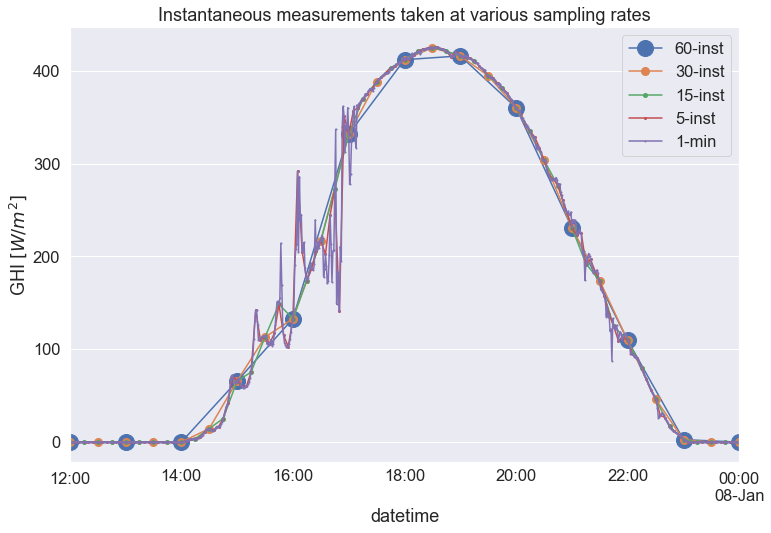

In [35]:
ax = weather60inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

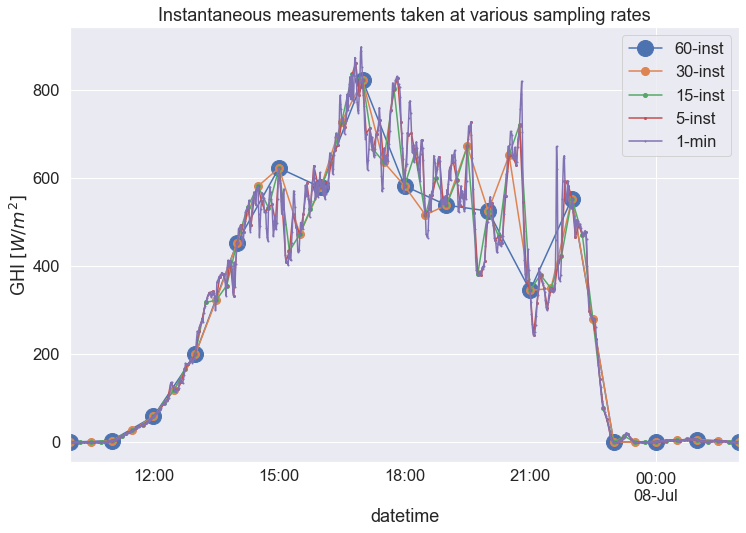

In [36]:
ax = weather60inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

Text(0, 0.5, 'GHI $[W/m^2]$')

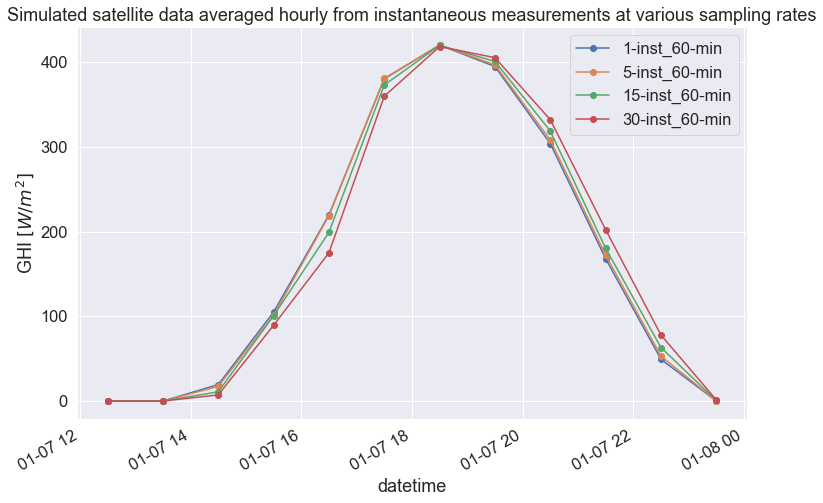

In [37]:
ax = weather.resample('H').mean().shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

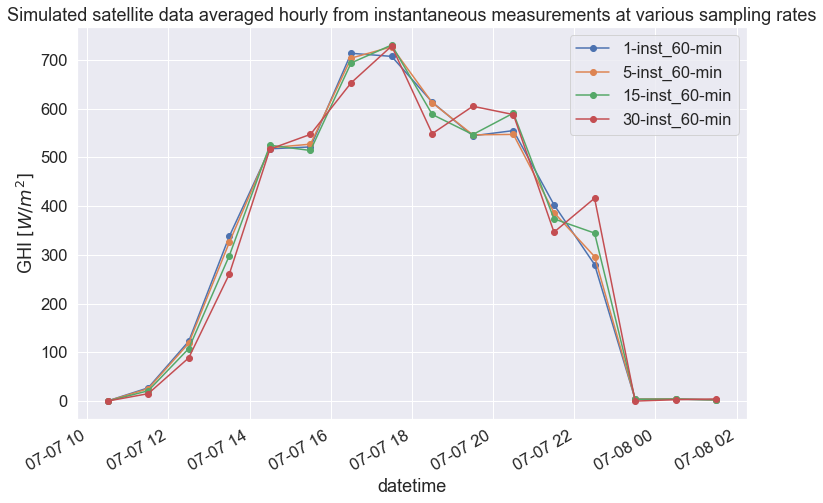

In [38]:
ax = weather.resample('H').mean().shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [39]:
weather.resample('H').mean()[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-01-07 12:00:00+00:00,0.000000,2.805000,0.000000,-15.608333,4.221667
2009-01-07 13:00:00+00:00,0.000000,3.588333,0.166667,-15.558333,4.296667
2009-01-07 14:00:00+00:00,19.500000,5.538333,24.061667,-15.221667,3.821667
2009-01-07 15:00:00+00:00,105.136667,21.086667,111.840000,-14.495000,4.715000
2009-01-07 16:00:00+00:00,219.755000,174.136667,174.295000,-13.570000,5.353333
2009-01-07 17:00:00+00:00,380.271667,742.708333,83.460000,-13.160000,6.083333
2009-01-07 18:00:00+00:00,420.348333,776.015000,85.048333,-12.891667,5.336667
2009-01-07 19:00:00+00:00,394.903333,754.038333,84.095000,-12.720000,6.228333
2009-01-07 20:00:00+00:00,303.980000,609.950000,102.041667,-12.563333,6.258333


## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

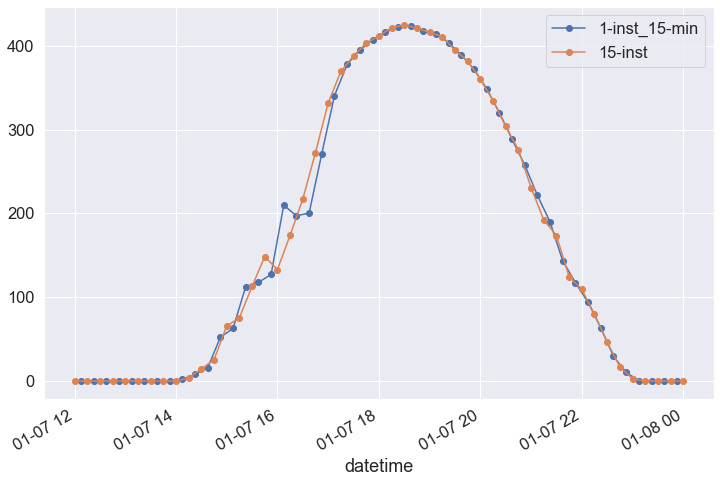

In [40]:
ax = weather.resample('15T').mean().shift(freq='450s')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

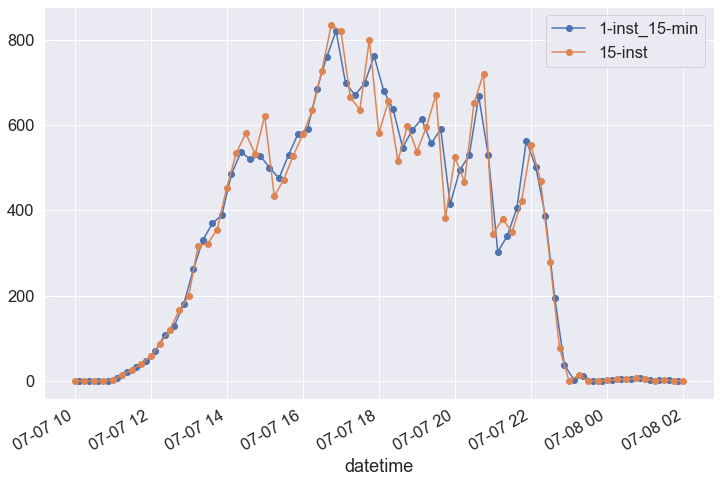

In [41]:
ax = weather.resample('15T').mean().shift(freq='450s')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [42]:
weather.resample('15T').mean()[f'{YEAR}-07-07T11:00:00{TZ}':f'{YEAR}-07-07T13:00:00{TZ}']

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2009-07-07 17:00:00+00:00,698.100000,328.553333,427.433333,25.026667,3.413333
2009-07-07 17:15:00+00:00,670.066667,228.406667,489.753333,25.340000,4.033333
2009-07-07 17:30:00+00:00,698.060000,236.713333,509.113333,25.686667,3.466667
2009-07-07 17:45:00+00:00,761.546667,329.253333,482.826667,25.860000,3.533333
2009-07-07 18:00:00+00:00,680.380000,247.173333,476.280000,26.133333,3.293333
2009-07-07 18:15:00+00:00,636.533333,217.880000,457.160000,26.113333,3.346667
2009-07-07 18:30:00+00:00,547.226667,146.320000,439.433333,26.413333,2.880000
2009-07-07 18:45:00+00:00,587.740000,129.500000,494.713333,26.733333,3.466667
2009-07-07 19:00:00+00:00,614.480000,138.480000,509.873333,26.853333,4.120000


# Time Averaged
This is the original clipping error problem.

In [43]:
# timestamps are at the beginning of the interval
weather5min = weather.resample('5T').mean()
weather15min = weather.resample('15T').mean()
weather30min = weather.resample('30T').mean()
weather60min = weather.resample('H').mean()

# Run Model
Now we _finally_ have all the files for 2010 that we need, we can finally run the model and calculate the clipping errors. We'll come back and run it for other years and other sites once we get it working.

In [44]:
# use 250kWac typical central inverter
INVERTERS = pvlib.pvsystem.retrieve_sam('CECInverter')
INVERTER_250K = INVERTERS['SMA_America__SC250U__480V_']
INVERTER_250K

Vac                          480
Pso                  2064.528564
Paco                    250000.0
Pdco               259022.859375
Vdco                       370.0
C0                          -0.0
C1                      0.000005
C2                      0.001166
C3                     -0.000893
Pnt                         75.0
Vdcmax                     480.0
Idcmax                700.061782
Mppt_low                   330.0
Mppt_high                  480.0
CEC_Date               4/16/2018
CEC_Type     Utility Interactive
Name: SMA_America__SC250U__480V_, dtype: object

In [45]:
# choose typical front-contact silicon modules
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')
# for now, for simplicity, just one mono-silicon module, mono
CECMOD_MONO = CECMODS['Canadian_Solar_Inc__CS6X_300M']
CECMOD_MONO

Technology            Mono-c-Si
Bifacial                      0
STC                      300.03
PTC                       273.6
A_c                       1.852
Length                    1.931
Width                     0.959
N_s                          72
I_sc_ref                   8.74
V_oc_ref                   45.0
I_mp_ref                   8.22
V_mp_ref                   36.5
alpha_sc               0.004326
beta_oc                -0.15372
T_NOCT                     44.3
a_ref                  1.861184
I_L_ref                8.745869
I_o_ref                     0.0
R_s                    0.366101
R_sh_ref             545.178589
Adjust                 4.722239
gamma_r                  -0.442
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_300M, dtype: object

In [46]:
# tracker positions
tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
surface_tilt = tracker['surface_tilt']
surface_azimuth = tracker['surface_azimuth']

In [47]:
# calculate irradiance inputs
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

In [48]:
# irrad components in plane of array
poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
aoi = tracker['aoi']
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
poa_direct = poa['poa_direct']
poa_diffuse = poa['poa_diffuse']
poa_global = poa['poa_global']
iam = pvlib.iam.ashrae(aoi)
effective_irradiance = poa_direct*iam + poa_diffuse

In [49]:
# cell temperature with 10-minute rolling average
module_efficiency = CECMOD_MONO.STC / (CECMOD_MONO.A_c*1000)
temp_cell = pvlib.temperature.pvsyst_cell(
    poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
    module_efficiency=module_efficiency).rolling('10T', center=True).mean()

<AxesSubplot:>

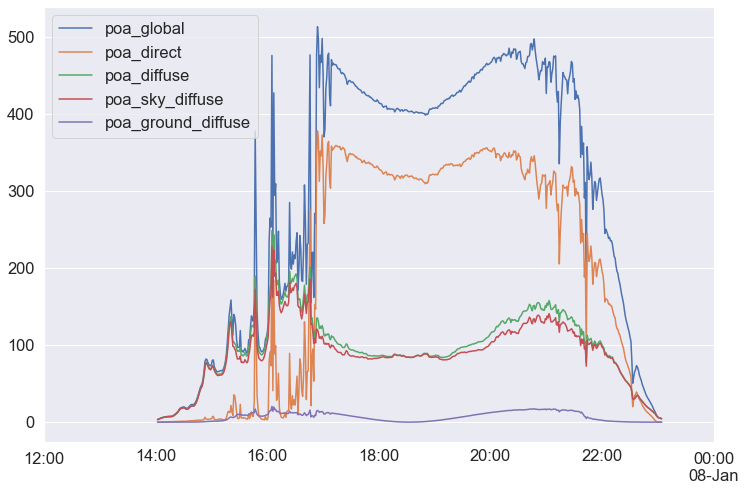

In [50]:
# the goods
poa[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

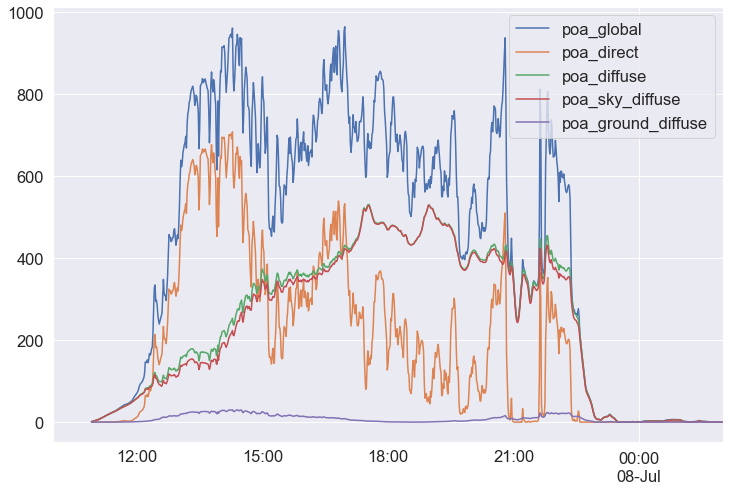

In [51]:
poa[JULY7_MORN:JULY7_NITE].plot()

In [52]:
# this is the magic
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        CECMOD_MONO.alpha_sc, CECMOD_MONO.a_ref,
        CECMOD_MONO.I_L_ref, CECMOD_MONO.I_o_ref,
        CECMOD_MONO.R_sh_ref, CECMOD_MONO.R_s, CECMOD_MONO.Adjust)
mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
mpp = pd.DataFrame(mpp, index=TIMES)

In [53]:
module_efficiency

0.16200323974082073

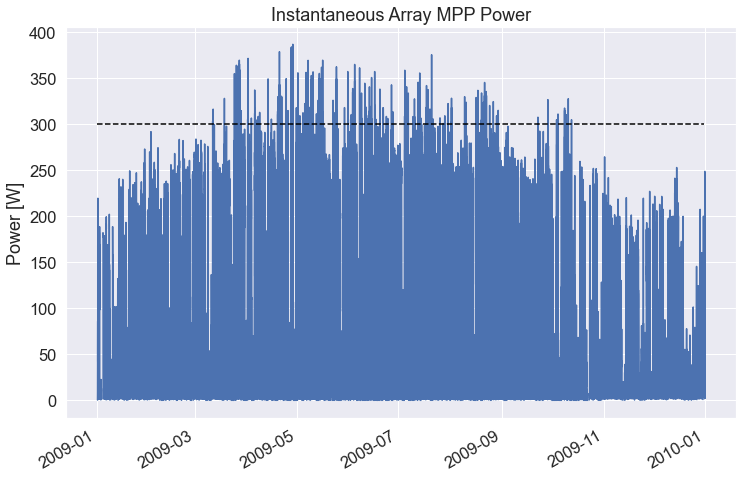

In [54]:
# the goods
mpp.p_mp.plot(title='Instantaneous Array MPP Power')
plt.hlines(xmin=f'{YEAR}-01-01', xmax=f'{YEAR}-12-31', y=CECMOD_MONO.STC, linestyles='--', colors='black')
plt.ylabel('Power [W]');

In [55]:
temp_ref = 25.0  # degC
dc_ac = 1.3
# maximum open circuit voltage
MAX_VOC = CECMOD_MONO.V_oc_ref + CECMOD_MONO.beta_oc * (tair.min() - temp_ref)
STRING_LENGTH = int(INVERTER_250K['Vdcmax'] // MAX_VOC)
STRING_VOLTAGE = STRING_LENGTH * MAX_VOC
STRING_OUTPUT = CECMOD_MONO.STC * STRING_LENGTH
STRING_COUNT = int(dc_ac * INVERTER_250K['Paco'] // STRING_OUTPUT)
DC_CAPACITY = STRING_COUNT * STRING_OUTPUT
DCAC = DC_CAPACITY / INVERTER_250K['Paco']
STRINGING_STATS = {
    'max Voc': MAX_VOC, 'string length': STRING_LENGTH, 'string voltage': STRING_VOLTAGE,
    'string output': STRING_OUTPUT, 'string count': STRING_COUNT, 'DC capacity': DC_CAPACITY,
    'DC/AC': DCAC}
STRINGING_STATS

{'max Voc': 53.654436,
 'string length': 8,
 'string voltage': 429.235488,
 'string output': 2400.24,
 'string count': 135,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

In [56]:
DC_OUTPUT = mpp.p_mp * STRING_LENGTH * STRING_COUNT
AC_OUTPUT = pvlib.inverter.sandia(
    mpp.v_mp * STRING_LENGTH,
    mpp.p_mp * STRING_LENGTH * STRING_COUNT,
    INVERTER_250K)
AC_OUTPUT.max()

250000.0

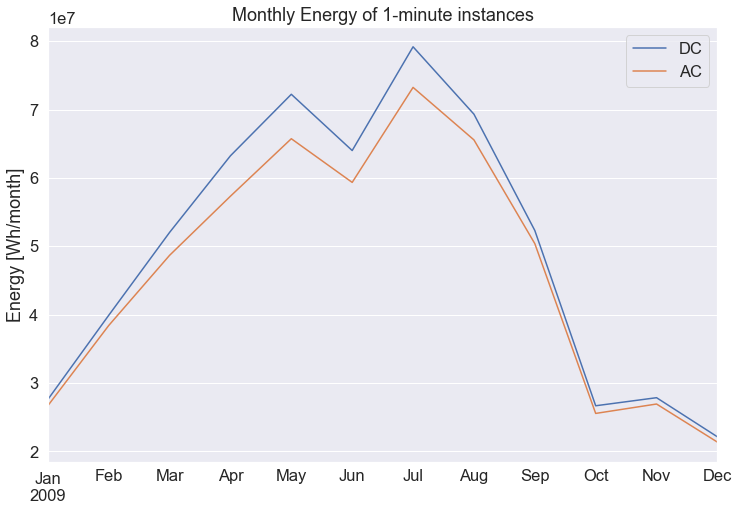

In [57]:
# the goods
EARRMPP = 1/60*DC_OUTPUT
EGRID = 1/60*AC_OUTPUT
ax = EARRMPP.resample('M').sum().plot(label='DC', title='Monthly Energy of 1-minute instances')
EGRID.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [58]:
print(f'1-minute instant annual DC & AC energy: {EARRMPP.sum()/1e6, EGRID.sum()/1e6} MWh')

1-minute instant annual DC & AC energy: (596.4732934101743, 559.1940997982417) MWh


<AxesSubplot:>

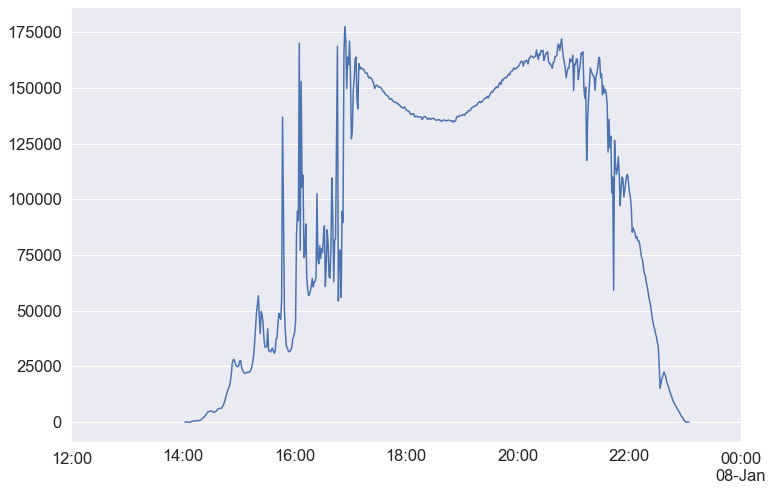

In [59]:
AC_OUTPUT[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

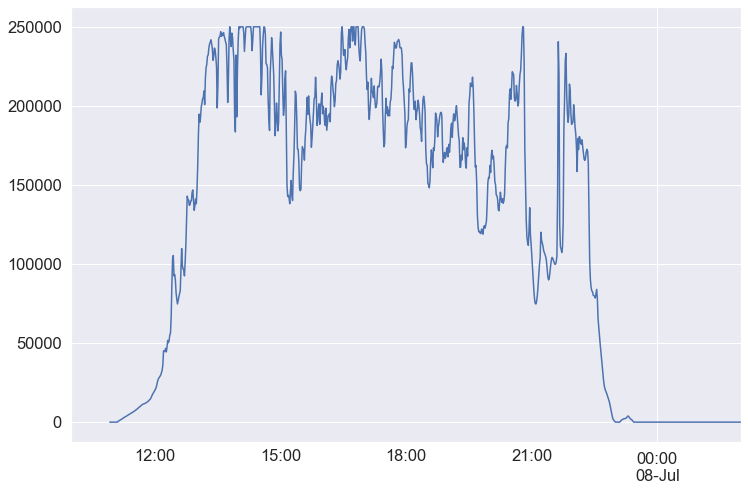

In [60]:
AC_OUTPUT[JULY7_MORN:JULY7_NITE].plot()

<AxesSubplot:>

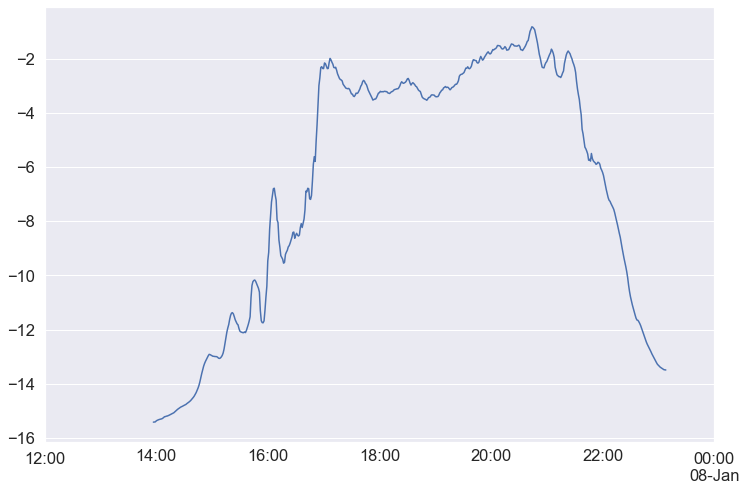

In [61]:
temp_cell[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

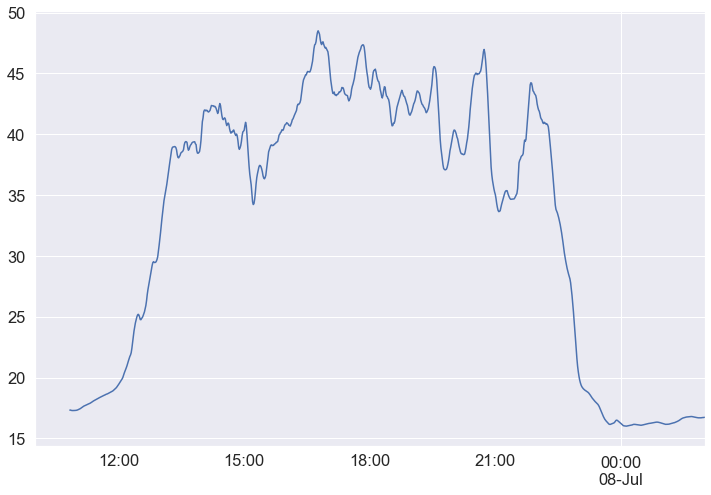

In [62]:
temp_cell[JULY7_MORN:JULY7_NITE].plot()

## More Convenient Functions
Create a function to automate the tasks above for all of datasets in the analysis.

### PV Model
This is a data class that just has the PV module and inverter parameters

### `calc_power()`
This is a function that outputs the instantaneous DC and AC power at each instant. Multiply output by the timestep in hours to get the energy.

### weather files
Now we use the convenience functions to loop over all 15 types of weather files.

#### instantaneous measurements
1. `weather`: 1-minute instantaneous
2. `weather5inst`: every 5th minute
3. `weather15inst`: every 15th minute
4. `weather30inst`: every 30th minute
5. `weather60inst`: once an hour

#### simulated satellite
instantaneous time-averaged to hourly
1. `weather60min`: 1-minute instances time-averaged to hourly
2. `weather5inst60min`: 5-minute instances time-average to hourly
3. `weather15inst60min`: 15-minute instances time-averaged to hourly
4. `weather30inst60min`: 30-minute instances time-averaged to hourly
5. `weather60inst`: once an hour

#### time-averaged
1. `weather`: 1-minute instantaneous
2. `weather5min`: 5-minute time-averaged
3. `weather15min`: 15-minute time-averaged
4. `weather30min`: 30-minute time-averaged
5. `weather60min`: 60-minute time-averaged

In [63]:
# some more convenient functions

@dataclass
class PVModel:
    latitude: float
    longitude: float
    elevation: float
    pvmodule : dict
    inverter : dict
    temp_ref: float = 25.0  # degC
    dc_ac: float = 1.3

    def string_array(self, tair) -> dict:
        # maximum open circuit voltage
        max_voc = self.pvmodule.V_oc_ref + self.pvmodule.beta_oc * (tair.min() - self.temp_ref)
        string_length = int(self.inverter['Vdcmax'] // max_voc)
        string_voltage = string_length * max_voc
        string_output = self.pvmodule.STC * string_length
        string_count = int(dc_ac * self.inverter['Paco'] // string_output)
        dc_capacity = string_count * string_output
        dc_ac_actual = dc_capacity / self.inverter['Paco']
        string_stats = {
            'max Voc': max_voc, 'string length': string_length, 'string voltage': string_voltage,
            'string output': string_output, 'string count': string_count, 'DC capacity': dc_capacity,
            'DC/AC': dc_ac_actual}
        return string_stats


def calc_power(df, pvmodel):
    # unpack weather
    times = df.index
    dni = df['DNI']
    ghi = df['GHI']
    dhi = df['DHI']
    tair = df['Temp']
    wspd = df['WS']

    # unpack pvmodel
    latitude = pvmodel.latitude
    longitude = pvmodel.longitude
    pvmodule = pvmodel.pvmodule
    inverter = pvmodel.inverter
    temp_ref = pvmodel.temp_ref
    dc_ac = pvmodel.dc_ac

    # string array
    string_stats = pvmodel.string_array(tair)
    string_length = string_stats['string length']
    string_count = string_stats['string count']

    # get solar position
    center_time = times.freq
    if center_time is None:
        center_time = times
    else:
        center_time = times.shift(freq=center_time/2)
    sp = pvlib.solarposition.get_solarposition(
        center_time, latitude, longitude)
    solar_zenith = sp.apparent_zenith.values
    solar_azimuth = sp.azimuth.values

    # tracker positions
    tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
    surface_tilt = tracker['surface_tilt']
    surface_azimuth = tracker['surface_azimuth']

    # calculate irradiance inputs
    dni_extra = pvlib.irradiance.get_extra_radiation(times).values

    # irrad components in plane of array
    poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
    aoi = tracker['aoi']
    poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
    poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
    poa_direct = poa['poa_direct']
    poa_diffuse = poa['poa_diffuse']
    poa_global = poa['poa_global']
    iam = pvlib.iam.ashrae(aoi)
    effective_irradiance = poa_direct*iam + poa_diffuse

    # cell temperature with 10-minute rolling average
    module_efficiency = pvmodule.STC / (pvmodule.A_c*1000)
    temp_cell = pvlib.temperature.pvsyst_cell(
        poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
        module_efficiency=module_efficiency).rolling('10T', center=True).mean()
    
    # this is the magic
    cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        pvmodule.alpha_sc, pvmodule.a_ref,
        pvmodule.I_L_ref, pvmodule.I_o_ref,
        pvmodule.R_sh_ref, pvmodule.R_s, pvmodule.Adjust)
    mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
    mpp = pd.DataFrame(mpp, index=times)

    # the goods
    dc_output = mpp.p_mp * string_length * string_count
    ac_output = pvlib.inverter.sandia(
        mpp.v_mp * string_length,
        mpp.p_mp * string_length * string_count,
        inverter)
    return dc_output, ac_output, string_stats

## PV model for Bondville, IL
This `PVModel` has the coordinates for Bondville, IL

In [64]:
pvmodel_bon = PVModel(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    elevation=ELEVATION,
    pvmodule=CECMOD_MONO,
    inverter=INVERTER_250K)

## 5-minute instances
test out the function on the 5-minute instances

In [65]:
dc_out_5inst, ac_out_5inst, string_stats = calc_power(df=weather5inst, pvmodel=pvmodel_bon)
string_stats

{'max Voc': 53.654436,
 'string length': 8,
 'string voltage': 429.235488,
 'string output': 2400.24,
 'string count': 135,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

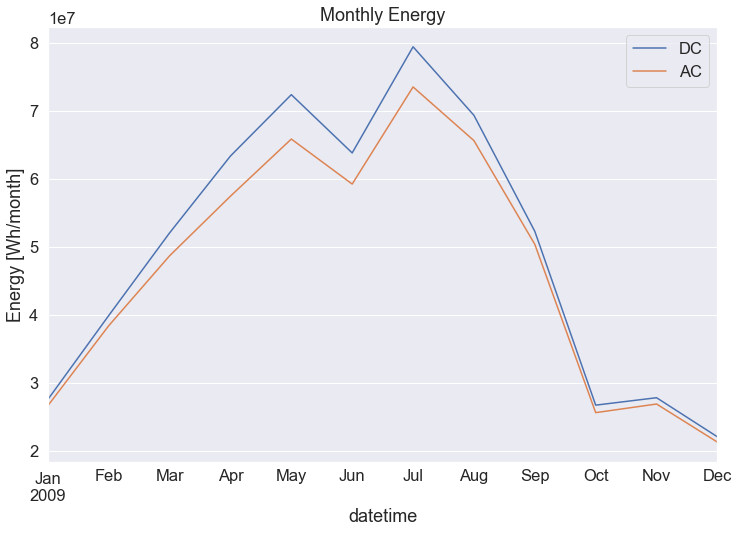

In [66]:
# the goods
earrmpp_5inst = 5/60*dc_out_5inst
egrid_5inst = 5/60*ac_out_5inst
ax = earrmpp_5inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_5inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [67]:
print(f'5-minute instant annual DC & AC energy: {earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6} MWh')

5-minute instant annual DC & AC energy: (596.9466538673173, 559.8654108086846) MWh


## 15-minute instances

In [68]:
dc_out_15inst, ac_out_15inst, _ = calc_power(df=weather15inst, pvmodel=pvmodel_bon)

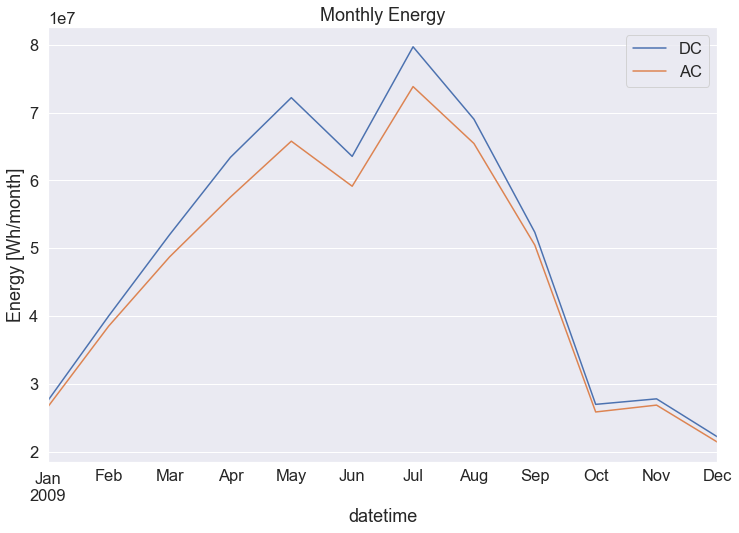

In [69]:
# the goods
earrmpp_15inst = 15/60*dc_out_15inst
egrid_15inst = 15/60*ac_out_15inst
ax = earrmpp_15inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_15inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [70]:
print(f'15-minute instant annual DC & AC energy: {earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6} MWh')

15-minute instant annual DC & AC energy: (596.7704906809532, 560.251029635829) MWh


## 30-minute instances

In [71]:
dc_out_30inst, ac_out_30inst, _ = calc_power(df=weather30inst, pvmodel=pvmodel_bon)

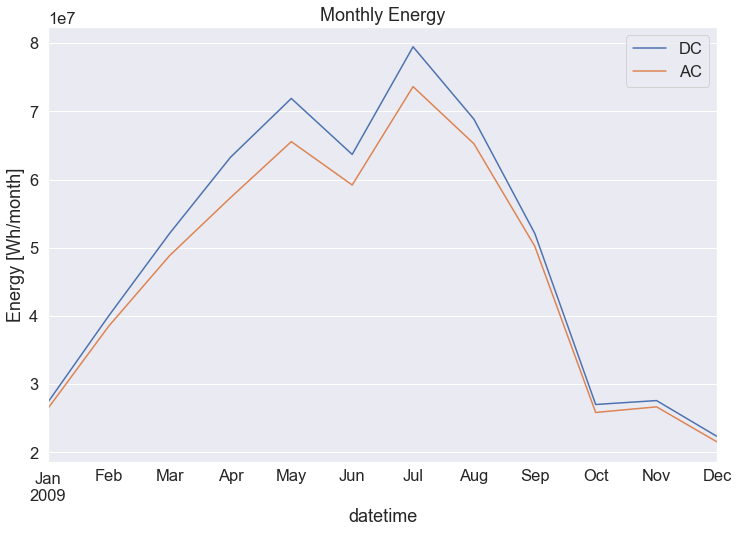

In [72]:
# the goods
earrmpp_30inst = 30/60*dc_out_30inst
egrid_30inst = 30/60*ac_out_30inst
ax = earrmpp_30inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_30inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [73]:
print(f'30-minute instant annual DC & AC energy: {earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6} MWh')

30-minute instant annual DC & AC energy: (595.7686433802587, 559.128097674894) MWh


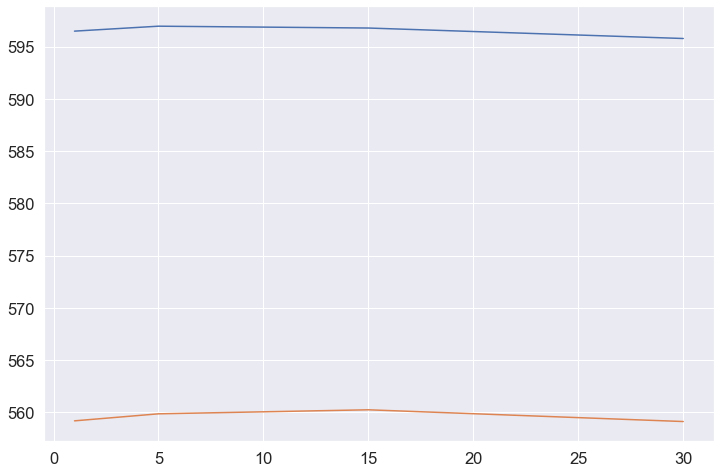

In [74]:
plt.plot(
    [1, 5, 15, 30],
    [(EARRMPP.sum()/1e6, EGRID.sum()/1e6),
     (earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6),
     (earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6),
     (earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6)])

## Automate
Run all the cases in a loop
1. instantaneous
2. satellite simulated
3. time-average

In [75]:
# loop over all instantaneous weather datasets
weather_inst = {
    1: weather, 5: weather5inst, 15: weather15inst, 30: weather30inst,
    60: weather60inst}
dc_out_inst = dict.fromkeys(weather_inst)
ac_out_inst = dict.fromkeys(weather_inst)
earrmpp_inst = dict.fromkeys(weather_inst)
egrid_inst = dict.fromkeys(weather_inst)
annual_energy_inst = dict.fromkeys(weather_inst)
for t, w in weather_inst.items():
    dc_out_inst[t], ac_out_inst[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_inst[t] = t/60*dc_out_inst[t]
    egrid_inst[t] = t/60*ac_out_inst[t]
    annual_energy_inst[t] = {
        'EArrMPP': earrmpp_inst[t].sum()/1e6, 'Egrid': egrid_inst[t].sum()/1e6}

,EArrMPP,Egrid
1,596.473293,559.194100
5,596.946654,559.865411
15,596.770491,560.251030
30,595.768643,559.128098
60,596.889851,558.968443


<AxesSubplot:>

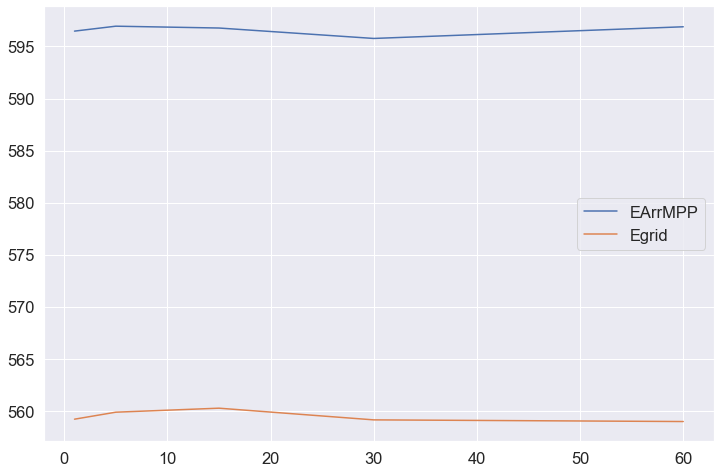

In [76]:
annual_energy_inst_df = pd.DataFrame(annual_energy_inst).T
display(annual_energy_inst_df)
annual_energy_inst_df.plot()

In [77]:
# loop over all instantaneous weather datasets time-averaged to hourly
weather_60min = {
    1: weather60min, 5: weather5inst60min, 15: weather15inst60min,
    30: weather30inst60min, 60: weather60inst}
dc_out_60min = dict.fromkeys(weather_60min)
ac_out_60min = dict.fromkeys(weather_60min)
earrmpp_60min = dict.fromkeys(weather_60min)
egrid_60min = dict.fromkeys(weather_60min)
annual_energy_60min = dict.fromkeys(weather_60min)
for t, w in weather_60min.items():
    dc_out_60min[t], ac_out_60min[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_60min[t] = dc_out_60min[t]
    egrid_60min[t] = ac_out_60min[t]
    annual_energy_60min[t] = {
        'EArrMPP': earrmpp_60min[t].sum()/1e6,
        'Egrid': egrid_60min[t].sum()/1e6}

,EArrMPP,Egrid
1,597.452054,568.152767
5,598.068880,568.350553
15,598.207491,567.125289
30,596.832120,563.838444
60,596.889851,558.968443


<AxesSubplot:>

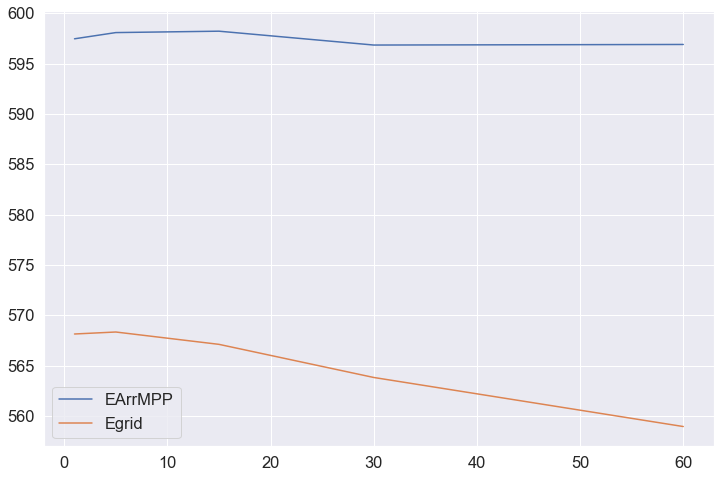

In [78]:
annual_energy_60min_df = pd.DataFrame(annual_energy_60min).T
display(annual_energy_60min_df)
annual_energy_60min_df.plot()

In [79]:
# loop over all time-averaged weather datasets
weather_avg = {
    1: weather, 5: weather5min, 15: weather15min, 30: weather30min,
    60: weather60min}
dc_out_avg = dict.fromkeys(weather_avg)
ac_out_avg = dict.fromkeys(weather_avg)
earrmpp_avg = dict.fromkeys(weather_avg)
egrid_avg = dict.fromkeys(weather_avg)
annual_energy_avg = dict.fromkeys(weather_avg)
for t, w in weather_avg.items():
    dc_out_avg[t], ac_out_avg[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_avg[t] = t/60*dc_out_avg[t]
    egrid_avg[t] = t/60*ac_out_avg[t]
    annual_energy_avg[t] = {
        'EArrMPP': earrmpp_avg[t].sum()/1e6, 'Egrid': egrid_avg[t].sum()/1e6}

,EArrMPP,Egrid
1,596.473293,559.194100
5,596.742457,562.716927
15,597.174712,565.590772
30,597.453628,567.008170
60,597.452054,568.152767


<AxesSubplot:>

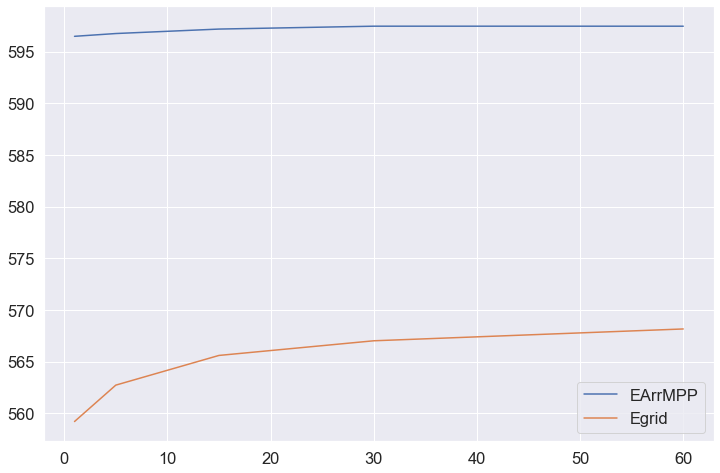

In [80]:
annual_energy_avg_df = pd.DataFrame(annual_energy_avg).T
display(annual_energy_avg_df)
annual_energy_avg_df.plot()

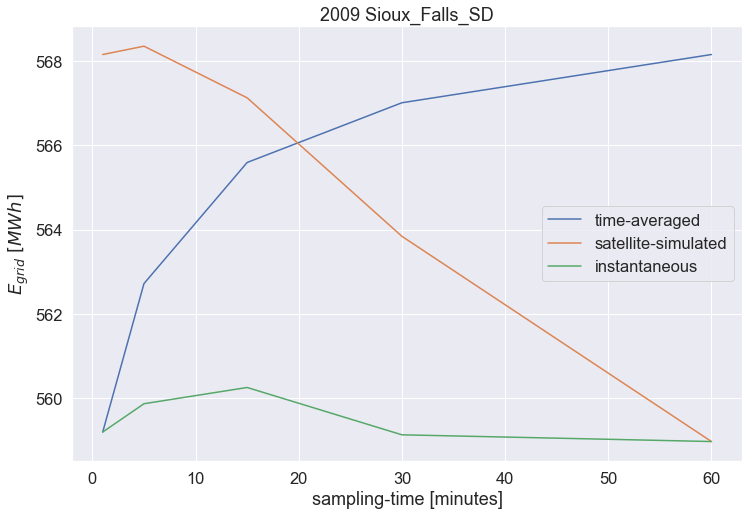

In [81]:
ax = annual_energy_avg_df['Egrid'].plot(label='time-averaged')
annual_energy_60min_df['Egrid'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['Egrid'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{grid}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()
plt.savefig(f'{CODENAME}{YEAR}.png');

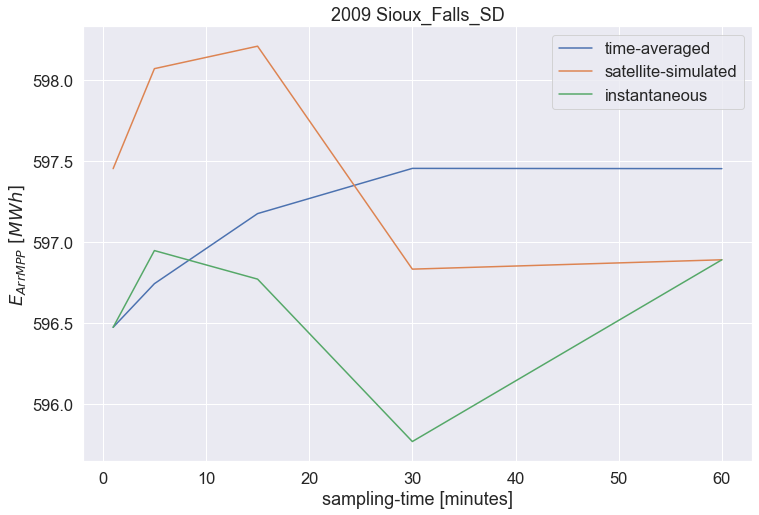

In [82]:
ax = annual_energy_avg_df['EArrMPP'].plot(label='time-averaged')
annual_energy_60min_df['EArrMPP'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['EArrMPP'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{ArrMPP}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()

In [83]:
100*(annual_energy_avg_df['Egrid'][60]/annual_energy_avg_df['Egrid'][1] - 1)

1.6020675856726951

In [84]:
100*(annual_energy_60min_df['Egrid'][30]/annual_energy_avg_df['Egrid'][1] - 1)

0.8305424956589036